## NIFTY 50(Market Index) Closing Price Forecasting Using Time Series Analysis with ARIMA Model

In [1]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


                                              0.0/614.7 kB ? eta -:--:--
     -                                     30.7/614.7 kB 660.6 kB/s eta 0:00:01
     -----                                 92.2/614.7 kB 880.9 kB/s eta 0:00:01
     -------------                          225.3/614.7 kB 1.5 MB/s eta 0:00:01
     ------------------------               389.1/614.7 kB 1.9 MB/s eta 0:00:01
     -------------------------------------  614.4/614.7 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 614.7/614.7 kB 2.3 MB/s eta 0:00:00
                                              0.0/2.8 MB ? eta -:--:--
     ---                                      0.3/2.8 MB 8.3 MB/s eta 0:00:01
     --------                                 0.6/2.8 MB 6.3 MB/s eta 0:00:01
     -----------                              0.8/2.8 MB 6.5 MB/s eta 0:00:01
     -------------                            0.9/2.8 MB 5.3 MB/s eta 0:00:01
     -----------------                        1.2/2.8 MB 6.0 MB/

In [3]:
stock_data = pd.read_csv(r"C:\Users\satyaki basak\Downloads\^NSEI (1).csv", 
    sep=',', 
    index_col='Date', 
    parse_dates=['Date'], 
    date_parser=lambda dates: pd.to_datetime(dates, format='%d-%m-%Y')  ).fillna(0)

In [4]:
stock_data.head()

,Close
Date,
2008-09-01,3921.199951
2008-10-01,2885.600098
2008-11-01,2755.100098
2008-12-01,2959.149902
2009-01-01,2874.800049


#### Visualising Nifty Closing Price

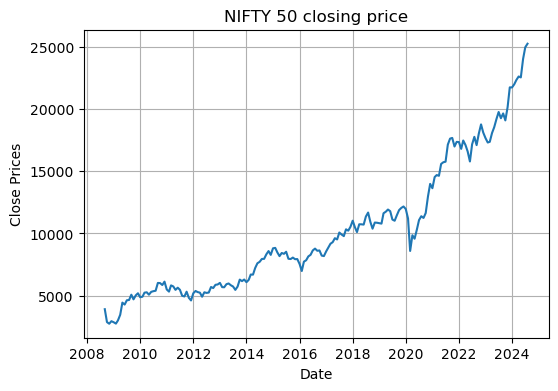

In [6]:
#plot close price
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('NIFTY 50 closing price')
plt.show()

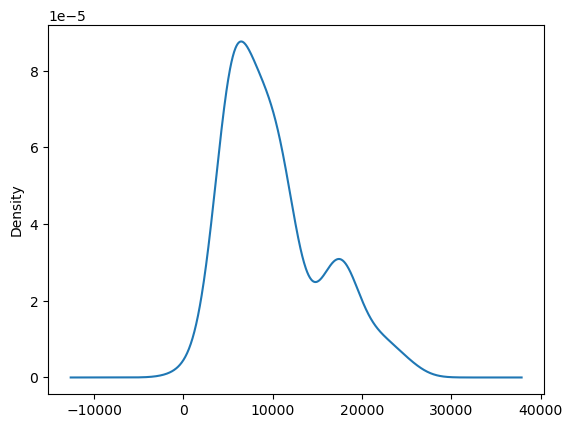

<Figure size 600x400 with 0 Axes>

In [11]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')
plt.figure(figsize=(6,4))
plt.show()

#### Test for Stationarity

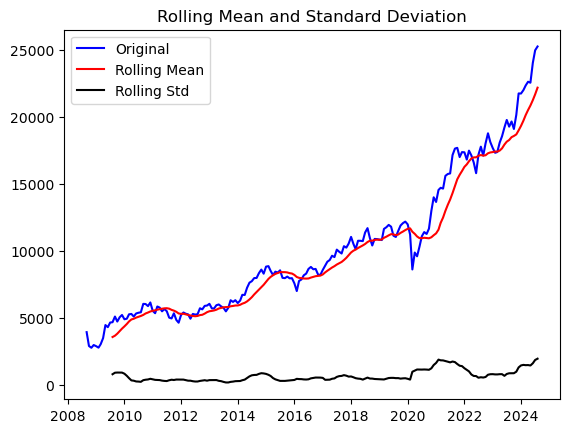

Results of dickey fuller test
Test Statistics                 -1.437697
p-value                          0.564076
No. of lags used                 3.000000
Number of observations used    189.000000
critical value (1%)             -3.465431
critical value (5%)             -2.876957
critical value (10%)            -2.574988
dtype: float64


In [12]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


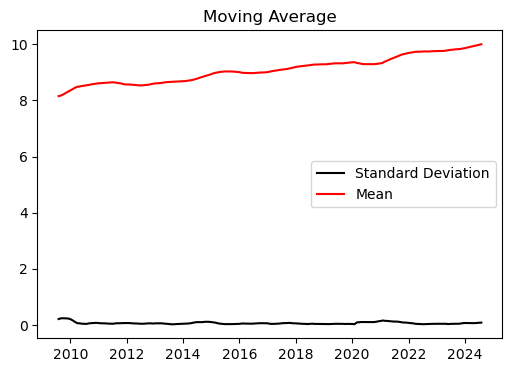

In [23]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

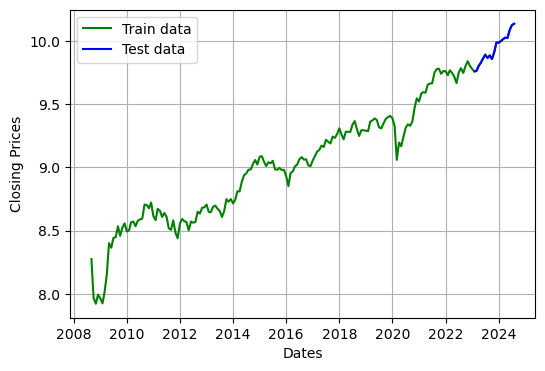

In [25]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-499.466, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-497.694, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-497.733, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-495.238, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-495.977, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.857 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  170
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 251.733
Date:                Sun, 01 Sep 2024   AIC                           -499.466
Time:                        18:57:39   BIC                           -493.206
Sample:                    12-01-2008   HQIC                          -496.926
                         - 01-01-2023                                       

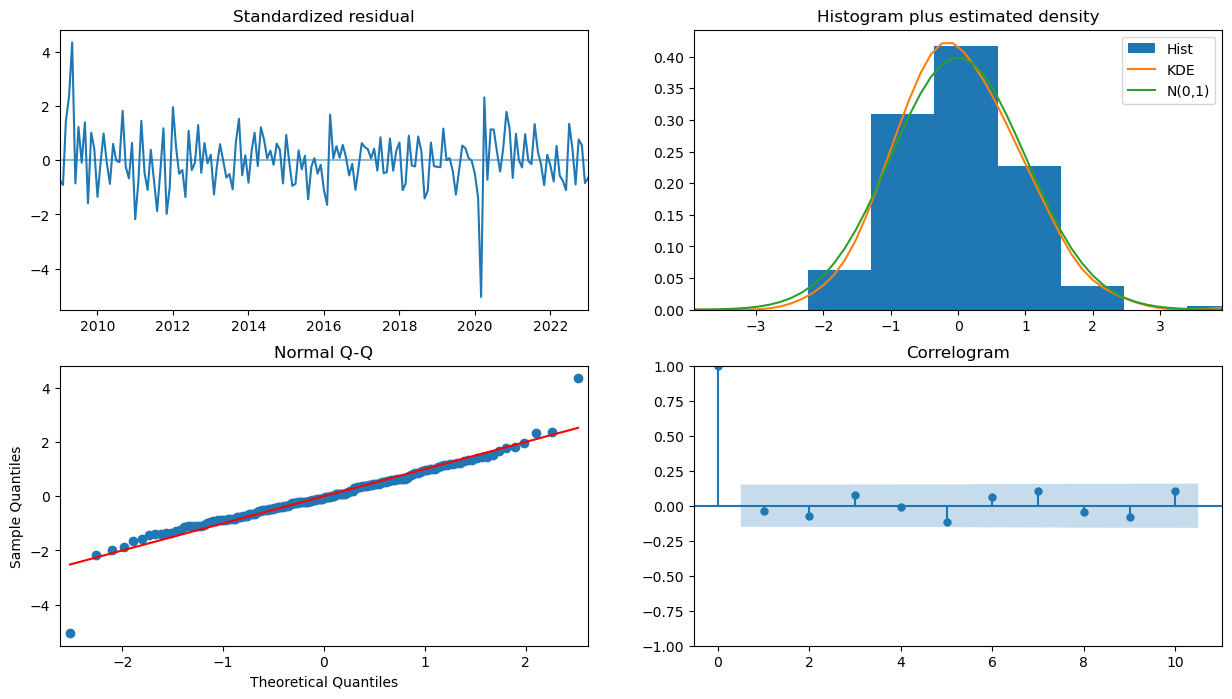

In [26]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [29]:
#As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.

#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit() 
print(fitted.summary())

C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  170
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 248.892
Date:                Sun, 01 Sep 2024   AIC                           -489.783
Time:                        19:02:21   BIC                           -477.264
Sample:                    12-01-2008   HQIC                          -484.703
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3949      1.412     -0.280      0.780      -3.162       2.372
ma.L1          0.4030      1.399      0.288      0.773      -2.340       3.146
ma.L2         -0.0444      0.076     -0.583      0.5

In [41]:
result = fitted.forecast(321, alpha=0.05)
print(result)


2023-02-01    9.780796
2023-03-01    9.781217
2023-04-01    9.781051
2023-05-01    9.781117
2023-06-01    9.781091
                ...   
2049-06-01    9.781098
2049-07-01    9.781098
2049-08-01    9.781098
2049-09-01    9.781098
2049-10-01    9.781098
Freq: MS, Name: predicted_mean, Length: 321, dtype: float64


In [43]:
 se = fitted.forecast(321, alpha=0.05)

In [44]:
fc= fitted.forecast(321, alpha=0.05)

In [45]:
conf= fitted.forecast(321, alpha=0.05)

In [46]:
result = fitted.forecast(321, alpha=0.05)
fc = result[0]
se = result[1]
conf = result[2]

In [52]:
conf

9.781050901483784

In [54]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf, index=test_data.index)
upper_series = pd.Series(conf, index=test_data.index)

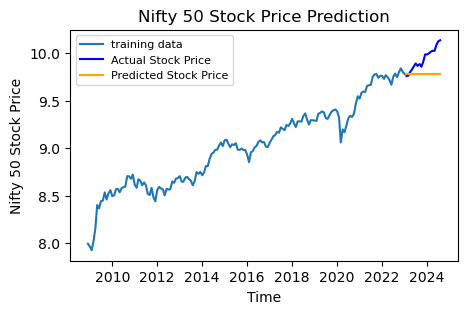

In [56]:
# Plot
plt.figure(figsize=(5,3), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nifty 50 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nifty 50 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [58]:
# report performance
mse = mean_squared_error(test_data)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

TypeError: mean_squared_error() missing 1 required positional argument: 'y_pred'